In [34]:
import numpy as np 
import csv
import matplotlib.pyplot as plt

v1 of a 2D prediction of the path the satellite takes using input npisy measurement data from the simulator

In [38]:
import numpy as np

class KalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_noise_covariance, measurement_noise_covariance):
        self.state = initial_state
        self.covariance = initial_covariance
        self.process_noise_covariance = process_noise_covariance
        self.measurement_noise_covariance = measurement_noise_covariance

    def predict(self, A):
        # Predict the next state
        self.state = A @ self.state
        # Predict the next covariance
        self.covariance = A @ self.covariance @ A.T + self.process_noise_covariance

    def update(self, measurement, H):
        # Compute Kalman gain
        K = self.covariance @ H.T @ np.linalg.inv(H @ self.covariance @ H.T + self.measurement_noise_covariance)
        # Update the state estimate
        self.state = self.state + K @ (measurement - H @ self.state)
        # Update the covariance matrix
        self.covariance = self.covariance - K @ H @ self.covariance

# Example usage

# gather noisy measuremnts from simulator
# Load noisy measurements from CSV file
noisy_measurements = []
with open('data_test.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        x, y = map(float, row)
        noisy_measurements.append([x, y])
        
noisy_measurements = np.array(noisy_measurements)

# Define initial state, covariance matrices, process noise covariance, and measurement noise covariance
initial_velocity_x = -7800
initial_velocity_y = 0
initial_position_x = noisy_measurements[0][0]
initial_position_y = noisy_measurements[0][1]

process_noise_variance = 1e-5  # Process noise variance # this needs to be discussed , not sure what it should be 
measurement_noise_variance = 1e-3  # Measurement noise variance # this changes with every measurement ??
initial_state = np.array([initial_position_x, initial_position_y, initial_velocity_x, initial_velocity_y])  # Initial position and velocity
initial_covariance = np.eye(4)  # Identity matrix
process_noise_covariance = np.eye(4) * process_noise_variance
measurement_noise_covariance = np.eye(2) * measurement_noise_variance

# Initialize Kalman filter
kf = KalmanFilter(initial_state, initial_covariance, process_noise_covariance, measurement_noise_covariance)

# Define state transition matrix (assuming simple gravtional and drag model)
gravitational_acceleration = 9.81  # Gravitational acceleration (m/s^2)
drag_coefficient = 0.01  # Drag coefficient
mass = 1000  # Satellite mass (kg)
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1 - drag_coefficient * dt / mass, 0],
              [0, 0, 0, 1 - drag_coefficient * dt / mass]])

# k1 and k2 are drag coefficients and m is the mass of the sattellite

# Define measurement matrix
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# List to store predicted positions and a list to store standrad deviation at each predicted position
predicted_positions = []
predicted_std = []

# Iterate over our noisy measurements
for measurement in noisy_measurements:
    # Prediction step
    kf.predict(A)
    # Update step
    kf.update(measurement, H)
    
    # Store predicted position
    predicted_positions.append(kf.state[:2])  # Only x, y coordinates, not velocity terms
    
    # along with predicted standard deviation of each predicted position
    predicted_std.append(np.sqrt(np.diag(kf.covariance))[:2])  # Only x, y coordinates, not velocity terms


# Convert lists to np arrays
predicted_positions = np.array(predicted_positions)
predicted_std = np.array(predicted_std)


# Final estimated state of the satellite
final_position = kf.state[0]
final_velocity = kf.state[1]

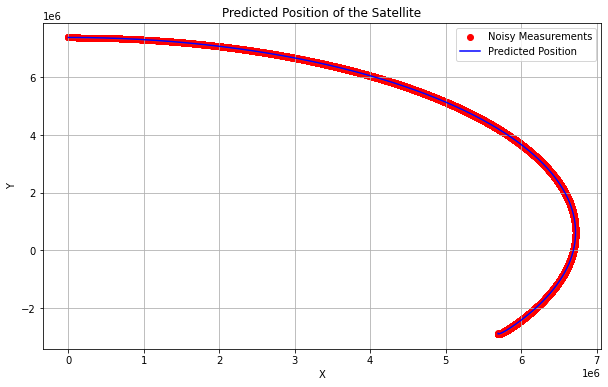

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(noisy_measurements[:, 0], noisy_measurements[:, 1], color='red', label='Noisy Measurements')
plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], color='blue', label='Predicted Position')
plt.fill_between(predicted_positions[:, 0] + predicted_std[:, 0], # Add shaded regions representing +- standard deviation
                 predicted_positions[:, 1] + predicted_std[:, 1], 
                 predicted_positions[:, 1] - predicted_std[:, 1], 
                 color='orange', alpha=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Predicted Position of the Satellite')
plt.legend()
plt.grid(True)
plt.show()

From the above plot, I think less data should be used, maybe a time step of 10 seconds.

In [40]:
print(predicted_std)

[[0.03161487 0.03161487]
 [0.03159071 0.03159071]
 [0.02884078 0.02884078]
 ...
 [0.01905502 0.01905502]
 [0.01905502 0.01905502]
 [0.01905502 0.01905502]]
